# 高维线性回归实验
下面，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为p。对于训练数据集和测试数据集中特征为x1,x2,…,xp的任一样本，我们使用如下的线性函数来生成该样本的标签：
y = 0.05 + $\sum_{i=1}^p$0.01x<sub>i</sub> + ϵ
其中噪声项ϵ服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度p=200；同时，我们特意把训练数据集的样本数设低，如20。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

In [2]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

# 从零开始实现
下面先介绍从零开始实现权重衰减的方法。我们通过在目标函数后添加L<sub>2</sub>范数惩罚项来实现权重衰减。

## 初始化模型参数
首先，定义随机初始化模型参数的函数。该函数为每个参数都附上梯度。

In [3]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 定义L<sub>2</sub>范数惩罚项
下面定义L<sub>2</sub>范数惩罚项。这里只惩罚模型的权重参数。

In [4]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

## 定义训练和测试
下面定义如何在训练数据集和测试数据集上分别训练和测试模型。与前面几节中不同的是，这里在计算最终的损失函数时添加了L<sub>2</sub>范数惩罚项。

In [5]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

## 观察过拟合
接下来，让我们训练并测试高维线性回归模型。当`lambd`设为0时，我们没有使用权重衰减。结果训练误差远小于测试集上的误差。这是典型的过拟合现象。

L2 norm of w: 14.115985870361328


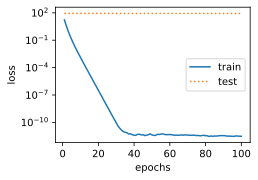

In [6]:
fit_and_plot(0)

## 使用权重衰减
下面我们使用权重衰减。可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解。另外，权重参数的L<sub>2</sub>范数比不使用权重衰减时的更小，此时的权重参数更接近0。

L2 norm of w: 0.03197580948472023


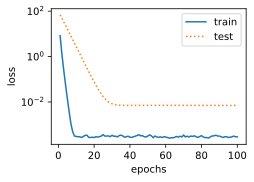

In [7]:
fit_and_plot(3)

# 简洁实现
这里我们直接在构造优化器实例时通过`weight_decay`参数来指定权重衰减超参数。默认下，PyTorch会对权重和偏差同时衰减。我们可以分别对权重和偏差构造优化器实例，从而只对权重衰减。

In [8]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)  # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())  # 输出L2范数

与从零开始实现权重衰减的实验现象类似，使用权重衰减可以在一定程度上缓解过拟合问题。

L2 norm of w: 13.03526782989502


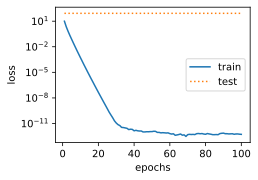

In [9]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.05465191230177879


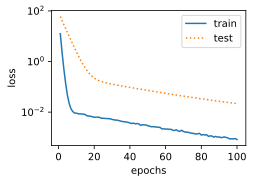

In [10]:
fit_and_plot_pytorch(3)

# 小结
+ 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
+ 权重衰减等价于L<sub>2</sub>范数正则化，通常会使学到的权重参数的元素较接近0。
+ 权重衰减可以通过优化器中的`weight_decay`超参数来指定。
+ 可以定义多个优化器实例对不同的模型参数使用不同的迭代方法。